# Present Wrapping Problem

In [2]:
%load_ext autoreload
%load_ext iminizinc
%matplotlib inline
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from z3 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The iminizinc extension is already loaded. To reload it, use:
  %reload_ext iminizinc


## Functions

In [3]:
def read_input(path):
    file = open(path,"r").readlines()
    w_paper , h_paper = tuple(map(int, file[0].rstrip("\n").split(" ")))
    n = int(file[1].rstrip("\n"))
    presents = []
    for i in range(2, n + 2):
        presents.append(list(map(int, file[i].rstrip("\n").split(" "))))
    return w_paper, h_paper, n, presents

In [4]:
def show_solutions(w_paper, h_paper, n, presents, solutions):
    colours = np.random.rand(n, 3)
    if not isinstance(solutions, list):
        solutions = [solutions]
    for x in solutions:
        bl_corners = x['bl_corners'] if 'bl_corners' in x else x
        print(x['bl_corners_xs'])
        print(x['bl_corners_ys'])
        show_solution(w_paper, h_paper, n, presents, bl_corners, colours)

def show_solution(w_paper, h_paper, n,presents, bl_corners, colours=None):
    if colours is None:
        colours = np.random.rand(n, 3)
    fig, ax = plt.subplots()
    for i in range(n):
        ax.add_patch(patches.Rectangle(
            bl_corners[i],
            presents[i][0],
            presents[i][1],
            facecolor=colours[i]
        ))
    ax.set_xlim(0, w_paper)
    ax.set_ylim(0, h_paper)
    plt.show()
    print(f"Solution: {bl_corners}")

## Input

In [69]:
min_instance, max_instance = 8, 20
#instance = np.random.randint(min_instance, high=max_instance + 1)
instance = 37
path = f"instances/{instance}x{instance}.txt"
w_paper, h_paper, n, presents = read_input(path)
bl_corners = []
print(f"Paper dimensions: {instance}x{instance}")
print(f"Presents dimensions: {presents}")

Paper dimensions: 37x37
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 11], [3, 12], [3, 13], [3, 14], [3, 17], [3, 18], [3, 21], [4, 3], [4, 4], [4, 5], [4, 6], [4, 10], [4, 22], [4, 24], [5, 3], [5, 4], [5, 6], [5, 10], [5, 14], [12, 37]]


## MiniZinc model

### First model 

In [29]:
%%mzn_model pwp-v1
include "globals.mzn";
int: w_paper;
int: h_paper;
int: n;
array[1..n, 1..2] of var 0..max(w_paper, h_paper) - 1: bl_corners;
array[1..n, 1..2] of int: presents;
constraint forall(i in 1..n) (bl_corners[i, 1] + presents[i, 1] <= w_paper);
constraint forall(i in 1..n) (bl_corners[i, 2] + presents[i, 2] <= h_paper);
constraint forall(i, j in 1..n where j > i) (
    max(bl_corners[i, 1], bl_corners[j, 1]) >= min(bl_corners[i, 1] + presents[i, 1], bl_corners[j, 1] + presents[j, 1]) \/
    max(bl_corners[i, 2], bl_corners[j, 2]) >= min(bl_corners[i, 2] + presents[i, 2], bl_corners[j, 2] + presents[j, 2])
);
solve satisfy;

In [32]:
%minizinc -s pwp-v1

%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=56
mzn-stat: flatIntVars=144
mzn-stat: flatBoolConstraints=28
mzn-stat: flatIntConstraints=184
mzn-stat: evaluatedHalfReifiedConstraints=56
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.0901909
mzn-stat-end
mzn-stat: initTime=0.00206
mzn-stat: solveTime=0.007317
mzn-stat: solutions=1
mzn-stat: variables=200
mzn-stat: propagators=206
mzn-stat: propagations=145600
mzn-stat: nodes=1888
mzn-stat: failures=939
mzn-stat: restarts=0
mzn-stat: peakDepth=25
mzn-stat-end


{'bl_corners': [[3, 6],
  [9, 8],
  [6, 7],
  [3, 0],
  [6, 0],
  [9, 0],
  [0, 0],
  [0, 9]]}

### Second model

In [34]:
%%mzn_model pwp-v2
include "globals.mzn";
int: w_paper;
int: h_paper;
int: n;
array[1..n, 1..2] of int: presents;
int: max_dim = max(w_paper, h_paper);
int: min_present_dim = min([min(presents[i, 1], presents[i, 2]) | i in 1..n]);

function var int: coord_to_value(var int: x, var int: y) = x + y * max_dim;
function var int: x_overlap(int: i, int: j) = 
    max(0, min(bl_corners[i, 1] + presents[i, 1], bl_corners[j, 1] + presents[j, 1]) - max(bl_corners[i, 1], bl_corners[j, 1]));
function var int: y_overlap(int: i, int: j) = 
    max(0, min(bl_corners[i, 2] + presents[i, 2], bl_corners[j, 2] + presents[j, 2]) - max(bl_corners[i, 2], bl_corners[j, 2]));
function var int: overlap_area(int: i, int: j) = x_overlap(i, j) * y_overlap(i, j);

array[1..n, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[1..n] of var 0..max_dim * max_dim: bl_corners_values;

predicate values_channeling(int: i) = 
    forall(i in 1..n) (bl_corners_values[i] == coord_to_value(bl_corners[i, 1], bl_corners[i, 2]));
constraint forall(i in 1..n) (values_channeling(i));

constraint alldifferent(bl_corners_values);
constraint count_eq(bl_corners_values, 0, 1);
constraint forall(i in 1..n) (bl_corners[i, 1] + presents[i, 1] <= w_paper);
constraint forall(i in 1..n) (bl_corners[i, 2] + presents[i, 2] <= h_paper);
constraint forall(i, j in 1..n where j > i) (overlap_area(i, j) == 0);
solve satisfy;

In [35]:
%minizinc -s pwp-v2

%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=8
mzn-stat: flatIntVars=300
mzn-stat: flatIntConstraints=322
mzn-stat: evaluatedReifiedConstraints=8
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.0892487
mzn-stat-end
mzn-stat: initTime=0.002217
mzn-stat: solveTime=0.002915
mzn-stat: solutions=1
mzn-stat: variables=308
mzn-stat: propagators=291
mzn-stat: propagations=42130
mzn-stat: nodes=359
mzn-stat: failures=174
mzn-stat: restarts=0
mzn-stat: peakDepth=23
mzn-stat-end


{'bl_corners': [[3, 6],
  [6, 8],
  [9, 7],
  [3, 0],
  [9, 0],
  [6, 0],
  [0, 0],
  [0, 9]],
 'bl_corners_values': [75, 102, 93, 3, 9, 6, 0, 108]}

### Third model

In [66]:
%%mzn_model pwp-v3
include "globals.mzn";
int: w_paper;
int: h_paper;
int: n;
int: max_dim = max(w_paper, h_paper);
array[1..n, 1..2] of 1..max_dim: presents;
array[1..n] of 1..max_dim: presents_xs = [presents[i, 1] | i in 1..n];
array[1..n] of 1..max_dim: presents_ys = [presents[i, 2] | i in 1..n];
int: min_present_dim = min([min(presents[i, 1], presents[i, 2]) | i in 1..n]);

function var int: coord_to_value(var int: x, var int: y) = x + y * max_dim;

array[1..n, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[1..n, 1..2] of var 1..max_dim: tr_corners;
array[1..n] of var 0..max_dim * max_dim: bl_corners_values;
array[1..n] of var 0..w_paper - min_present_dim: bl_corners_xs;
array[1..n] of var 0..h_paper - min_present_dim: bl_corners_ys;

predicate values_channeling(int: i) = 
    forall(i in 1..n) (bl_corners_values[i] == coord_to_value(bl_corners[i, 1], bl_corners[i, 2]));
constraint forall(i in 1..n) (values_channeling(i));

predicate bl_corners_channeling(int: i) = 
    forall(i in 1..n) (bl_corners[i, 1] == bl_corners_xs[i] /\ bl_corners[i, 2] == bl_corners_ys[i]);
constraint forall(i in 1..n) (bl_corners_channeling(i));

predicate tr_corners_channeling(int: i) = 
    forall(i in 1..n) (bl_corners[i, 1] + presents[i, 1] == tr_corners[i, 1] /\ bl_corners[i, 2] + presents[i, 2] == tr_corners[i, 2]);
constraint forall(i in 1..n) (tr_corners_channeling(i));

constraint alldifferent(bl_corners_values);
constraint count_eq(bl_corners_values, 0, 1);
constraint diffn_k(bl_corners, presents);
constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);
solve satisfy;

In [67]:
%minizinc -s pwp-v3

%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1033
mzn-stat: flatIntVars=134
mzn-stat: flatBoolConstraints=253
mzn-stat: flatIntConstraints=1125
mzn-stat: evaluatedReifiedConstraints=23
mzn-stat: evaluatedHalfReifiedConstraints=1010
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.165834
mzn-stat-end
mzn-stat: initTime=0.010186
mzn-stat: solveTime=0.003949
mzn-stat: solutions=1
mzn-stat: variables=1173
mzn-stat: propagators=1276
mzn-stat: propagations=21665
mzn-stat: nodes=170
mzn-stat: failures=68
mzn-stat: restarts=0
mzn-stat: peakDepth=34
mzn-stat-end


### Fourth model

In [ ]:
%%mzn_model pwp-v4
include "globals.mzn";
int: w_paper;
int: h_paper;
int: n;
int: max_dim = max(w_paper, h_paper);
array[1..n, 1..2] of 1..max_dim: presents;
array[1..n] of 1..max_dim: presents_xs = [presents[i, 1] | i in 1..n];
array[1..n] of 1..max_dim: presents_ys = [presents[i, 2] | i in 1..n];
int: min_present_dim = min([min(presents[i, 1], presents[i, 2]) | i in 1..n]);

function var int: coord_to_value(var int: x, var int: y) = x + y * max_dim;
function var int: rotate_by_180(int: i) = coord_to_value(w_paper - bl_corners[i, 1] - presents[i, 1], h_paper - bl_corners[i, 2] - presents[i, 2]);

array[1..n, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[1..n, 1..2] of var 1..max_dim: tr_corners;
array[1..n] of var 0..max_dim * max_dim: bl_corners_values;
array[1..n] of var 0..w_paper - min_present_dim: bl_corners_xs;
array[1..n] of var 0..h_paper - min_present_dim: bl_corners_ys;

predicate values_channeling(int: i) = 
    forall(i in 1..n) (bl_corners_values[i] == coord_to_value(bl_corners[i, 1], bl_corners[i, 2]));
constraint forall(i in 1..n) (values_channeling(i));

predicate bl_corners_channeling(int: i) = 
    forall(i in 1..n) (bl_corners[i, 1] == bl_corners_xs[i] /\ bl_corners[i, 2] == bl_corners_ys[i]);
constraint forall(i in 1..n) (bl_corners_channeling(i));

predicate tr_corners_channeling(int: i) = 
    forall(i in 1..n) (bl_corners[i, 1] + presents[i, 1] == tr_corners[i, 1] /\ bl_corners[i, 2] + presents[i, 2] == tr_corners[i, 2]);
constraint forall(i in 1..n) (tr_corners_channeling(i));

%constraint lex_lesseq(bl_corners_values, [rotate_by_180(i) | i in 1..n]);

constraint alldifferent(bl_corners_values);
constraint count_eq(bl_corners_values, 0, 1);
constraint diffn_k(bl_corners, presents);
constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);
solve satisfy;

In [ ]:
solutions = %minizinc -s pwp-v4

[0, 2, 0]
[0, 0, 2]


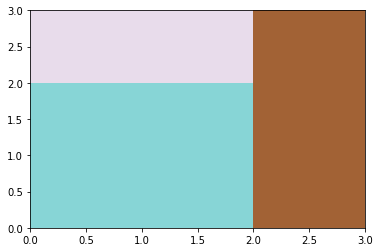

Solution: [[0, 0], [2, 0], [0, 2]]
[1, 0, 1]
[0, 0, 2]


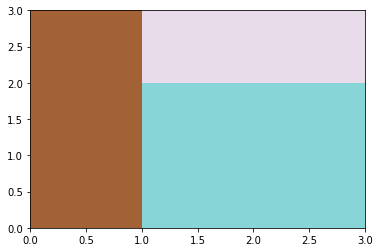

Solution: [[1, 0], [0, 0], [1, 2]]
[0, 2, 0]
[1, 0, 0]


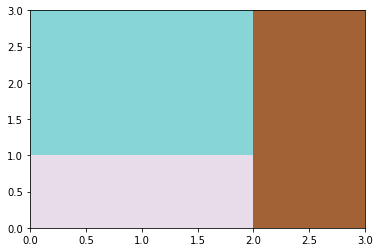

Solution: [[0, 1], [2, 0], [0, 0]]
[1, 0, 1]
[1, 0, 0]


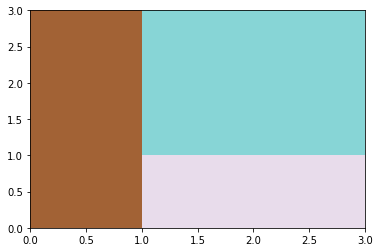

Solution: [[1, 1], [0, 0], [1, 0]]


In [45]:
show_solutions(w_paper, h_paper, n, presents, solutions)

## SMT model

In [119]:
def z3max(x,y):
    return If(x > y, x, y)

def z3min(x,y):
    return If(x < y, x, y)

bl_corners= [ [ Int("c_%s_%s" % (i, j)) for j in range(2) ] for i in range(n) ]
domain = [And(0<=bl_corners[i][0],bl_corners[i][0]<w_paper,0<=bl_corners[i][1],bl_corners[i][1]< h_paper) for i in range(n)]
overflow = [And(bl_corners[i][0]+presents[i][0]<=w_paper,bl_corners[i][1]+presents[i][1]<=h_paper) for i in range(n)]
pp(bl_corners)
intersection = [ And(
    Or(
        z3max(bl_corners[i][0],bl_corners[j][0])>=z3min(bl_corners[i][0]+presents[i][0],bl_corners[j][0]+presents[j][0]),
        z3max(bl_corners[i][1],bl_corners[j][1])>=z3min(bl_corners[i][1]+presents[i][1],bl_corners[j][1]+presents[j][1])
     )) for i in range(n) for j in range(i+1,n) ]

[[c_0_0, c_0_1],
 [c_1_0, c_1_1],
 [c_2_0, c_2_1],
 [c_3_0, c_3_1],
 [c_4_0, c_4_1],
 [c_5_0, c_5_1],
 [c_6_0, c_6_1],
 [c_7_0, c_7_1],
 [c_8_0, c_8_1],
 [c_9_0, c_9_1],
 [c_10_0, c_10_1],
 [c_11_0, c_11_1],
 [c_12_0, c_12_1],
 [c_13_0, c_13_1],
 [c_14_0, c_14_1],
 [c_15_0, c_15_1],
 [c_16_0, c_16_1],
 [c_17_0, c_17_1],
 [c_18_0, c_18_1],
 [c_19_0, c_19_1],
 [c_20_0, c_20_1],
 [c_21_0, c_21_1]]


In [121]:
%%time
s = Solver()
s.add(domain + overflow + intersection)
s.check()
sol = s.model()
solution=[[sol[bl_corners[i][0]], sol[bl_corners[i][1]]] for i in range(n)]
solution

CPU times: user 15min 5s, sys: 1.69 s, total: 15min 7s
Wall time: 15min 8s


[[18, 12],
 [8, 31],
 [18, 15],
 [15, 29],
 [18, 28],
 [18, 20],
 [8, 22],
 [11, 0],
 [18, 0],
 [15, 10],
 [8, 0],
 [0, 0],
 [14, 0],
 [4, 0],
 [14, 4],
 [4, 5],
 [11, 10],
 [0, 23],
 [11, 18],
 [0, 3],
 [4, 12],
 [21, 0]]